In [1]:
"""
This notebook is used to analyse the dino reconstruction loss
"""

'\nThis notebook is used to analyse the dino reconstruction loss\n'

In [2]:
import json
# add the parent directory to the Python path
import sys
import os
sys.path.append(os.path.abspath("../.."))   # one level up from notebook/
import matplotlib.pyplot as plt
import torch
from data.utils.dataloaders import get_imagenet_dataloader


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

In [5]:
# Paths (adjust if your files differ)
RECON_JSON = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json"

# Load reconstruction dataset (list of dicts with fields: image_id, k_value, vgg_error, mse_error, ...)
with open(RECON_JSON, 'r') as f:
    reconstruction_dataset = json.load(f)

print('Sizes:', len(reconstruction_dataset))
print('Sample entry:', reconstruction_dataset[0])

Sizes: 450000
Sample entry: {'image_id': 0, 'k_value': 1, 'L1Loss': 0.19351771473884583, 'LPIPS': 0.6646087765693665, 'LPIPS_layers': [0.11964087188243866, 0.14834865927696228, 0.11373482644557953, 0.1480303555727005, 0.13485409319400787], 'DINOv2FeatureLoss': 0.525488018989563}


In [6]:
# from data.utils.dataloaders import get_imagenet_dataloader
imagenet_val = get_imagenet_dataloader(split="val_categorized", batch_size=4)

In [7]:
# find image index with lowest and highest DINO loss
# the image_id is already stored in reconstruction_dataset entries
LPIPS_losses = [[entry['image_id'], entry['LPIPS'], entry["k_value"]] for entry in reconstruction_dataset]
LPIPS_losses.sort(key=lambda x: x[1])  # sort by loss value
lowest_LPIPS = LPIPS_losses[0:10]
highest_LPIPS = LPIPS_losses[-10:]
print("Lowest DINO losses (image_id, loss, k_value):", lowest_LPIPS)
print("Highest DINO losses (image_id, loss, k_value):", highest_LPIPS)

Lowest DINO losses (image_id, loss, k_value): [[43078, 0.020792722702026367, 256], [40666, 0.021393034607172012, 256], [21128, 0.023335659876465797, 256], [40666, 0.027370497584342957, 128], [21128, 0.02837967313826084, 64], [30765, 0.030492573976516724, 128], [21128, 0.031863339245319366, 128], [30765, 0.03533882275223732, 256], [40666, 0.036984484642744064, 64], [43078, 0.037247367203235626, 128]]
Highest DINO losses (image_id, loss, k_value): [[35002, 1.0033555030822754, 1], [15447, 1.0158780813217163, 1], [15471, 1.022432804107666, 1], [47272, 1.0232534408569336, 1], [47532, 1.0285496711730957, 1], [5748, 1.0430611371994019, 2], [31643, 1.0617222785949707, 2], [47197, 1.066697120666504, 2], [28715, 1.0780755281448364, 1], [47532, 1.0791053771972656, 2]]


In [8]:
lowest_LPIPS_img_indexes = [item[0] for item in lowest_LPIPS]
highest_LPIPS_img_indexes = [item[0] for item in highest_LPIPS]

In [9]:
lowest_images = [imagenet_val.dataset[idx][0] for idx in lowest_LPIPS_img_indexes]
highest_images = [imagenet_val.dataset[idx][0] for idx in highest_LPIPS_img_indexes]

In [10]:
# Group entries by k_value for per-k plots
from collections import defaultdict

k_to_entries = defaultdict(list)  # k -> list of (image_id, dino_loss)
for e in reconstruction_dataset:
    try:
        k = int(e.get('k_value', -1))
    except Exception:
        continue
    img_id = e.get('image_id')
    loss = e.get('LPIPS')
    if img_id is None or loss is None:
        continue
    k_to_entries[k].append((img_id, float(loss)))

ks_sorted = sorted(k_to_entries.keys())
print('k values found:', ks_sorted)

k values found: [1, 2, 4, 8, 16, 32, 64, 128, 256]


In [11]:
# Minimal resolver from image_id to dataset index
def _resolve_index(image_id):
    # Many pipelines store the dataset index as image_id; try to parse it
    try:
        return int(image_id)
    except Exception:
        return None

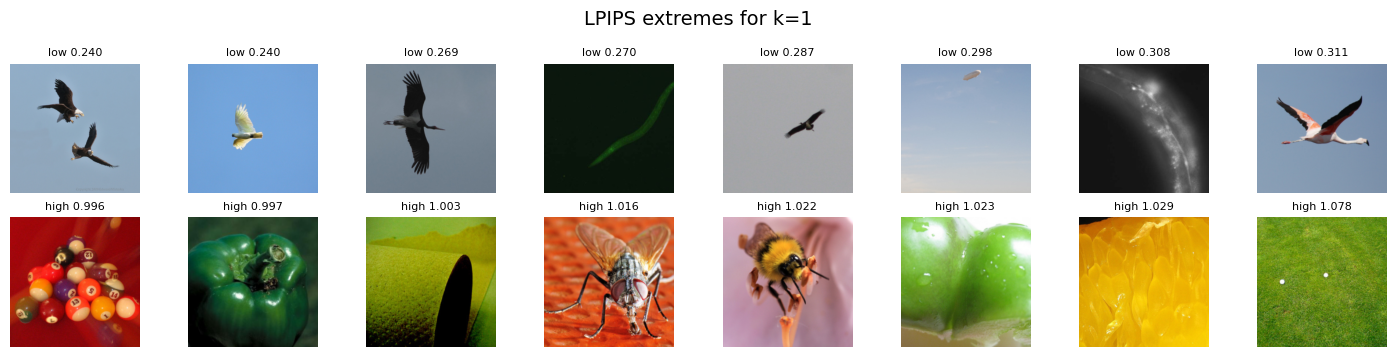

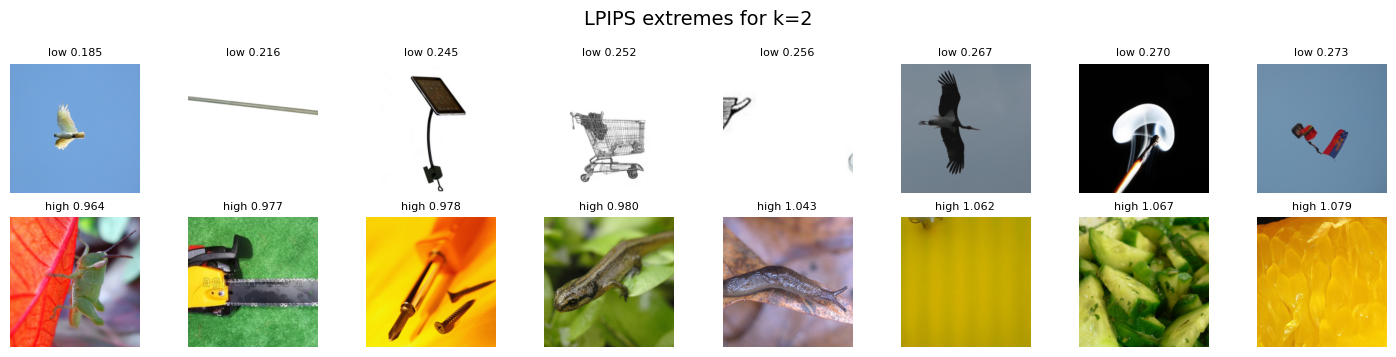

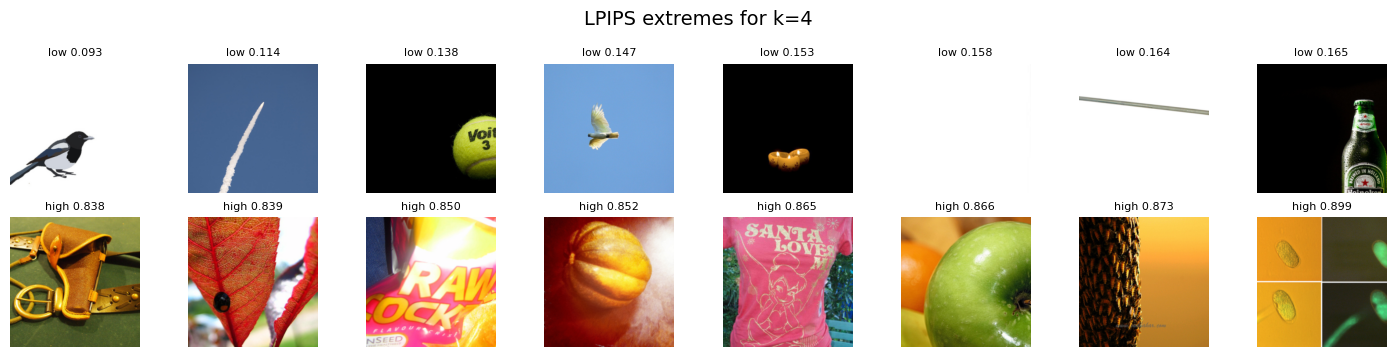

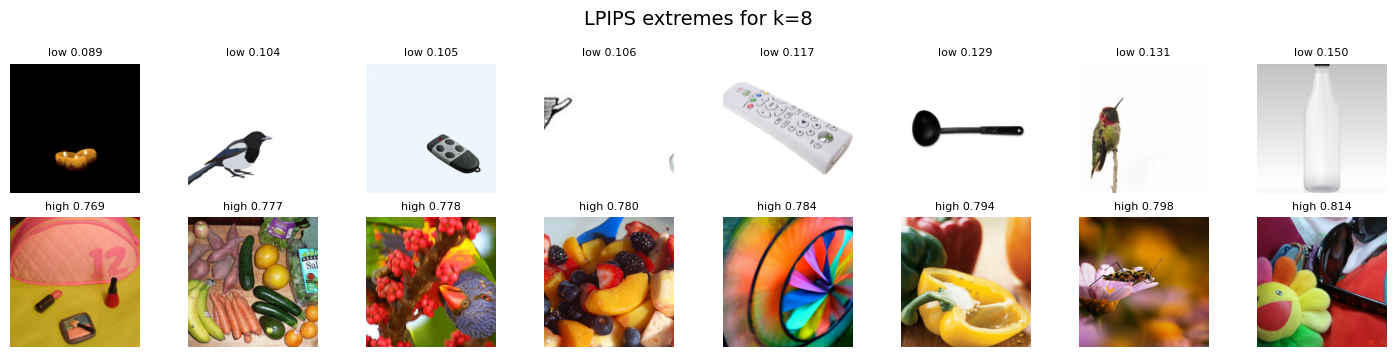

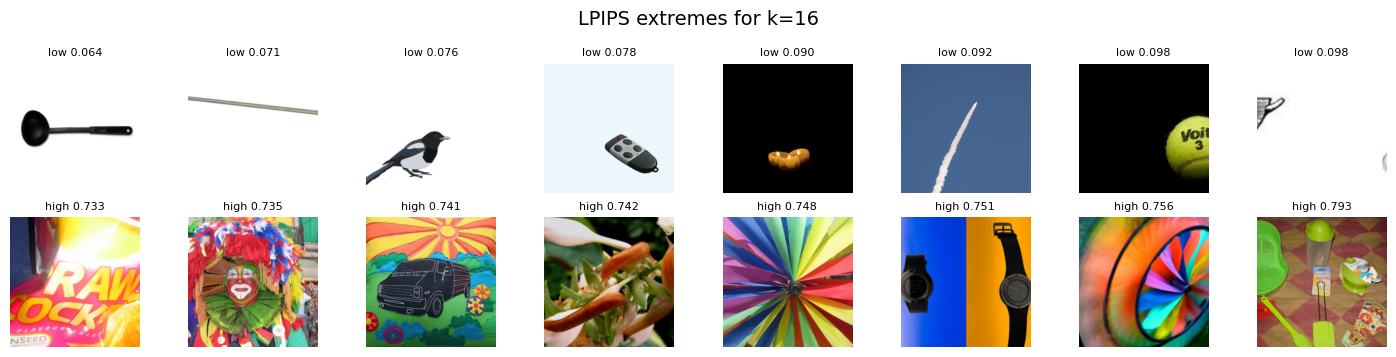

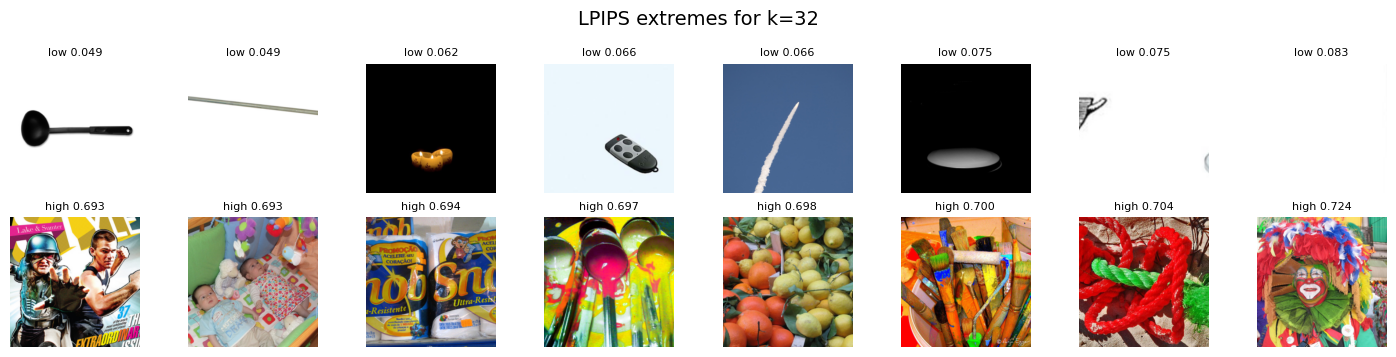

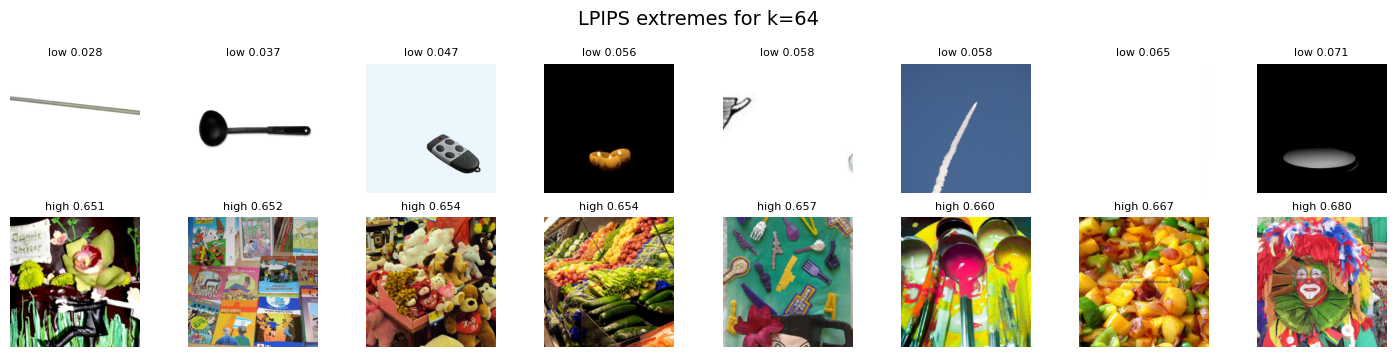

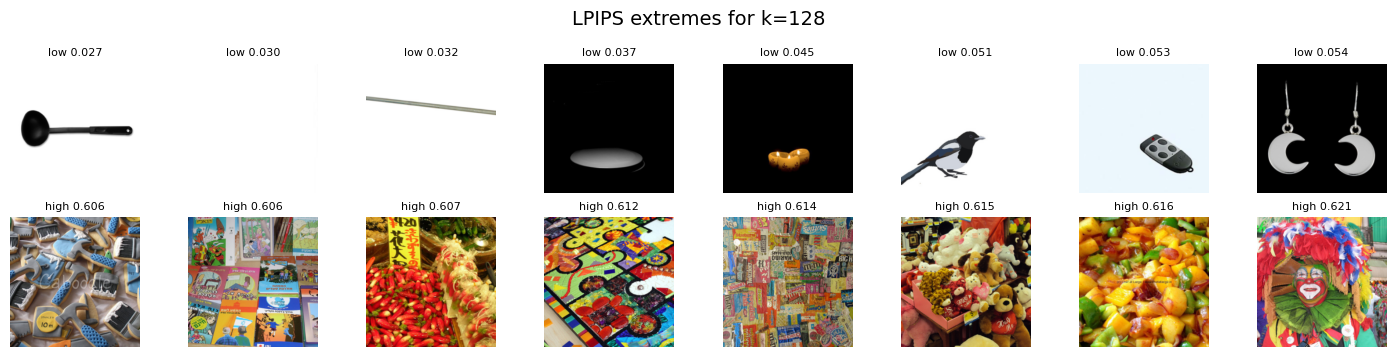

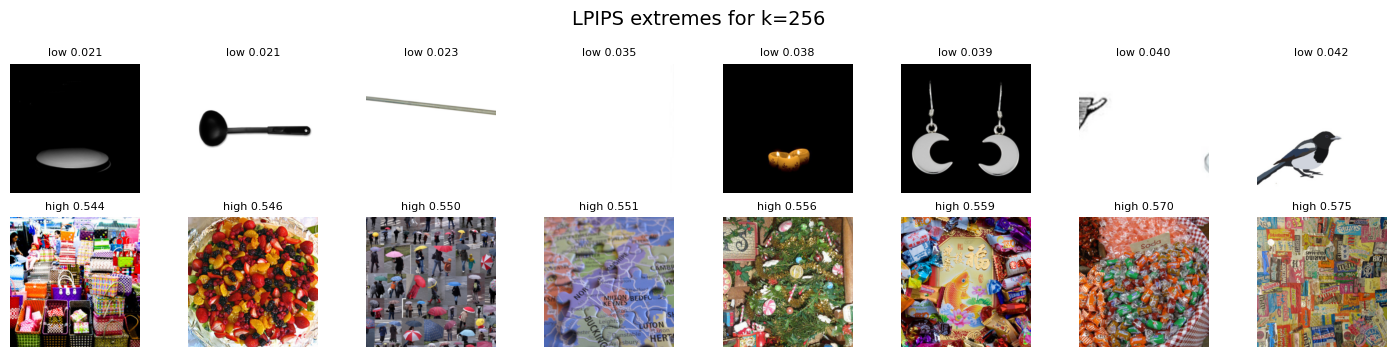

In [14]:
# Plot per-k lowest/highest DINO losses
N_PER_SIDE = 8
for k in ks_sorted:
    entries = k_to_entries[k]
    if not entries:
        continue
    # sort by loss
    entries_sorted = sorted(entries, key=lambda x: x[1])
    lows = entries_sorted[:N_PER_SIDE]
    highs = entries_sorted[-N_PER_SIDE:]
    num_low = len(lows)
    num_high = len(highs)
    cols = max(num_low, num_high)
    if cols == 0:
        print(f"k={k}: no entries")
        continue
    fig, axes = plt.subplots(2, cols, figsize=(1.8*cols, 3.6))
    fig.suptitle(f"LPIPS extremes for k={k}", fontsize=14)
    # First row: lowest
    for i in range(cols):
        ax = axes[0, i]
        ax.axis('off')
        if i < num_low:
            img_id, loss_val = lows[i]
            img_t = imagenet_val.dataset[img_id][0]  # CHW, normalized
            img = denormalize(img_t).clamp(0, 1).permute(1, 2, 0).cpu()
            ax.imshow(img)
            ax.set_title(f"low {loss_val:.3f}", fontsize=8)
    # Second row: highest
    for i in range(cols):
        ax = axes[1, i]
        ax.axis('off')
        if i < num_high:
            img_id, loss_val = highs[i]
            img_t = imagenet_val.dataset[img_id][0]
            img = denormalize(img_t).clamp(0, 1).permute(1, 2, 0).cpu()
            ax.imshow(img)
            ax.set_title(f"high {loss_val:.3f}", fontsize=8)
    plt.tight_layout()
    plt.savefig(f"/BS/data_mani_compress/work/thesis/thesis/output/reconstruction_losses/lpips_extremes_k_{k}.pdf")
    plt.show()